# Notebook Dedicado a Explorar Datos Reales candidatos a solar Nue y Guardar los Datos que seran usados para Construir el Dataset de ML en otro Notebook

In [43]:
import uproot
import numpy as np

import glob
import re

import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

# Read Files

In [2]:
main_dir = 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV/'
fname_pattern = 'real_data_solar_analysis_*.root'

flist = glob.glob(main_dir + fname_pattern)

def alpha_num_sort(list_route):
    # Función auxiliar para extraer número de la ruta
    def extract_num(route):
        # Busca el primer número en el nombre del archivo
        match = re.search(r'(\d+)', route)
        return int(match.group(1)) if match else -1  # Si no hay número, devuelve -1

    # Ordena la lista usando el número extraído
    return sorted(list_route, key=extract_num)

#flist = flist.sort(key=orden_natural)
flist = alpha_num_sort(flist)
flist

['E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_0.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_1.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_10.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_11.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_12.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_13.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_14.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_15.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_16.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_17.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_18.root',
 'E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\\real_data_solar_analysis_19.r

In [6]:
file = uproot.open(flist[0])
print(file.keys())
data = file['T;1']
np.unique(np.array(data['energy'])).shape

['T;1', 'pmt;1']


(757,)

In [8]:
data = file['T;1']
data.keys()

['energy',
 'evtid',
 'evtid_bi214',
 'ev_time_day',
 'ev_time_sec',
 'ev_time_nanosec',
 'position',
 'pos_position_error',
 'neg_position_error',
 'dc_flag',
 'neck_nhit_pmt',
 'hit_pmtid',
 'hit_pmttime',
 'clockCount50',
 'hit_residual']

# Solar Direction Function

In [9]:
def sun_direction(UTdays, UTsecs, UTnsecs):

    #Esta funcion no recibe un array de numeros! solo valores numericos y no listas.
    # Constantes
    labtwist_degrees = -49.58
    pi = np.pi
    twopi = 2 * pi
    to_rad = pi / 180.0

    # Offset en días: diferencia entre el tiempo cero de SNO+ (1 Jan 2010) y Jan 0, 2000
    days_offset = 2451543.5 - 2455197.5

    # Días desde Jan 0, 2000
    days = UTdays + UTsecs / 86400.0 + UTnsecs / (1.0e9 * 86400.0) - days_offset

    # Constantes astronómicas
    ecl = (23.4393 - 3.563E-7 * days) * to_rad
    w = (282.9404 + 4.70935E-5 * days) * to_rad
    e = 0.016709 - 1.151E-9 * days
    ma = (356.0470 + 0.9856002585 * days) * to_rad

    # Eccentric anomaly
    ea = ma + e * np.sin(ma) * (1.0 + e * np.cos(ma))

    # Dirección hacia el Sol (coordenadas eclípticas)
    xv = np.cos(ea) - e
    yv = np.sqrt(1.0 - e * e) * np.sin(ea)

    # True anomaly
    v = np.arctan2(yv, xv)

    # Longitud solar
    sun_longitude = v + w

    # Coordenadas geocéntricas eclípticas
    xs = np.cos(sun_longitude)
    ys = np.sin(sun_longitude)
    vec1 = np.array([
        ys * np.cos(ecl),
        ys * np.sin(ecl),
        xs
    ])

    # Rotación terrestre diaria
    k0 = 0.27499
    k1 = 1.0 + 1.0 / 365.2425
    spin = k0 + k1 * days
    spin_angle = (spin - int(spin)) * twopi

    # Latitud y longitud del detector (en radianes)
    longitude = (81 + 12 / 60 + 5 / 3600) * to_rad
    latitude = (46 + 28 / 60 + 31.0 / 3600) * to_rad
    labtwist = labtwist_degrees * to_rad

    # Rotaciones: Z(labtwist) * X(latitude) * Y(longitude - spin_angle)
    def rotation_matrix_y(angle):
        return np.array([
            [np.cos(angle), 0, np.sin(angle)],
            [0, 1, 0],
            [-np.sin(angle), 0, np.cos(angle)]
        ])

    def rotation_matrix_x(angle):
        return np.array([
            [1, 0, 0],
            [0, np.cos(angle), -np.sin(angle)],
            [0, np.sin(angle), np.cos(angle)]
        ])

    def rotation_matrix_z(angle):
        return np.array([
            [np.cos(angle), -np.sin(angle), 0],
            [np.sin(angle), np.cos(angle), 0],
            [0, 0, 1]
        ])

    rot = (
        rotation_matrix_z(labtwist) @
        rotation_matrix_x(latitude) @
        rotation_matrix_y(longitude - spin_angle)
    )

    sun_dir = rot @ vec1  # Producto matriz * vector

    return sun_dir  # Es un array de 3 elementos: [x, y, z]

# Analysis Function - Data Selection, cos alpha computatation and Data Storing

In [257]:
#Function to Compute the radial position of events
def magnitude(vector): 
    x = vector[:,0]
    y = vector[:,1]
    z = vector[:,2]

    r = np.sqrt(x**2 + y**2 + z**2)
    r = r.astype(np.float32)
    return r

#Analysis code settings  ------------------------------
out_file_dir = 'analysis_out/en_up_2_pt_5_MeV/'

#Data Cuts:
energy_inf_cut = 2.5
energy_sup_cut = 12

time_res_inf_cut = -5.0
time_res_sup_cut = 7.0

posr_cut = 5000
# -------------------------------------------------------

for i_dx, input_file_dir in enumerate(flist):
    print(f'In file {input_file_dir}')
    
    #Load the Data:
    load_data = uproot.open(input_file_dir)
    
    #select the tree of event data and PMT info
    TTree_data_name = load_data.keys()[0]
    TTree_pmt_info_name = load_data.keys()[-1]
    
    event_data = load_data[TTree_data_name]
    pmt_data = load_data[TTree_pmt_info_name]
    
    #event info to be used:
    var_event_list = ['evtid', 'evtid_bi214', 'energy', 'position', 'hit_pmtid', 
                      'hit_residual', 'dc_flag', 'ev_time_day', 
                      'ev_time_sec', 'ev_time_nanosec', 'clockCount50']  #list the name of the varibles to be extracted and used for the solarnu analysis.
    
    #pmt info to be used
    var_pmt_list = ['pmt_id', 'pmt_pos_xyz', 'pmt_type']
    
    #Observables to save
    var_name_save_list = ['evtid', 'evtid_bi214', 'energy', 'posr', 'hit_residual', 'clockCount50']
    multi_cos_alpha = np.array([]) #create the empty list of the cos_alpha for the multiple PMTs record
    
    # Extract the variables with the name of the var_event_list in numpy.array from the .root file
    observables = {}
    
    # Cargar variables del árbol de eventos
    for var_name_i in var_event_list:
        observables[var_name_i] = np.array(event_data[var_name_i])
    
        # Transformar clockCount50
        if var_name_i == 'clockCount50':
            observables['clockCount50'] = observables['clockCount50'] * 20
    
    # Calcular posr
    observables['posr'] = magnitude(observables['position'])
    
    # Cargar variables del árbol de PMTs
    for var_name_i in var_pmt_list:
        observables[var_name_i] = np.array(pmt_data[var_name_i])
    
    # Filtrado de pmt_type válido
    pmt_type_condition = (observables['pmt_type'] == 1)
    pmt_id_valid = observables['pmt_id'][pmt_type_condition]
    
    # Condiciones
    hit_pmt_id_condition = np.in1d(observables['hit_pmtid'], pmt_id_valid)
    energy_condition = (observables['energy'] >= energy_inf_cut) & (observables['energy'] <= energy_sup_cut)
    time_res_condition = (observables['hit_residual'] >= time_res_inf_cut) & (observables['hit_residual'] <= time_res_sup_cut)
    posr_condition = (observables['posr'] <= posr_cut)
    
    general_condition = hit_pmt_id_condition & energy_condition & time_res_condition & posr_condition
    
    # Aplicar condición general a las variables del evento
    for var_name_i in var_event_list:
        observables[var_name_i] = observables[var_name_i][general_condition]
    observables['posr'] = observables['posr'][general_condition]

    print(f'selected energies form {input_file_dir}: {observables['energy']} with shape {observables['energy'].shape}')
    
    # Guardar variables deseadas
    for var_name_i in var_name_save_list:
        np.save(out_file_dir + var_name_i + f'_{i_dx}.npy', observables[var_name_i])
    
    N_samples = len(observables['hit_residual'])
    
    for sample_idx in range(N_samples):
        Utime_day = observables['ev_time_day'][sample_idx]
        Utime_sec = observables['ev_time_sec'][sample_idx]
        Utime_nsec = observables['ev_time_nanosec'][sample_idx]
    
        sun_dir = sun_direction(UTdays=Utime_day, UTsecs=Utime_sec, UTnsecs=Utime_nsec) * (-1)
    
        pmt_hit_id = observables['hit_pmtid'][sample_idx]
        pmt_hit_xyz = observables['pmt_pos_xyz'][pmt_hit_id]
    
        norm2 = np.linalg.norm(pmt_hit_xyz)
        pmt_hit_xyz = pmt_hit_xyz / norm2
    
        dot_prod = np.dot(sun_dir, pmt_hit_xyz)
        cos_alpha = dot_prod
    
        multi_cos_alpha = np.append(multi_cos_alpha, cos_alpha)
    
    # Guardar los cos(alpha)
    np.save(out_file_dir + 'cos_alpha' + f'_{i_dx}.npy', multi_cos_alpha)

In file E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\real_data_solar_analysis_0.root
selected energies form E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\real_data_solar_analysis_0.root: [2.9662776  2.9662776  2.9662776  ... 2.60217214 2.60217214 2.60217214] with shape (9596,)
In file E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\real_data_solar_analysis_1.root
selected energies form E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\real_data_solar_analysis_1.root: [2.72914648 2.72914648 2.72914648 ... 4.34379816 4.34379816 4.34379816] with shape (2427,)
In file E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\real_data_solar_analysis_10.root
selected energies form E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\real_data_solar_analysis_10.root: [6.74756765 6.74756765 6.74756765 ... 3.41705561 3.41705561 3.41705561] with shape (1004,)
In file E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\real_data_solar_analysis_11.root
selected energies form E:/Data/solarnu_Realdata/energy_up_2_pt_5_MeV\real_

# Load the saved numpy observables for Analysis

In [258]:
main_dir = 'analysis_out/en_up_2_pt_5_MeV/'

observable_name = ['evtid', 'evtid_bi214', 'energy', 'posr', 'cos_alpha', 'hit_residual']

for var_i in observable_name:
    print(f'preparing observable {var_i}')
    #Prepare the empty arrays of the observables
    locals()[var_i] = np.array([])
    #create the file lists of the  fragemented observable in loop
    flist_var_i = alpha_num_sort(glob.glob(main_dir + var_i + '_*.npy'))

    for file_i in flist_var_i:
        locals()[var_i] = np.append(locals()[var_i], np.load(file_i))

#Prepare the empty arrays of the observables

preparing observable evtid
preparing observable evtid_bi214
preparing observable energy
preparing observable posr
preparing observable cos_alpha
preparing observable hit_residual


## Remove Redundant Values

In [259]:
# Empty lists which will contain de non-repeated values of the observables for singles events
energy_ev = []  #flatten list structure
posr_ev = []    #flatten list structure
evtid_ev = []   #flatten list structure
evtid_bi214_ev = []  #flatten list structure
cos_alpha_ev = []  #List filled with np.arrays() where each array correspond to and event
time_residual_ev = [] #List filled with np.arrays() where each array correspond to and event


#evID index break list
data_break_i = [0]  #array whose elements are the index from where an event start and end.

N_data = len(evtid)

for i_dx in range(N_data - 1):
    if evtid[i_dx] != evtid[i_dx+1]:
        data_break_i.append(i_dx+1)

#add the last index to complete the data_break_i list
data_break_i.append(N_data - 1)

N_terms = len(data_break_i)

#Start to save the non-redundant values and separate the time residuals and angles for each event
for i_dx in range(N_terms - 2):
    init_i = data_break_i[i_dx]
    final_i = data_break_i[i_dx+1]

    #energy
    energy_ev_i = energy[init_i : final_i]
    #print(energy_ev_i)
    energy_ev.append(energy_ev_i[0])

    #position
    posr_ev_i = posr[init_i : final_i]
    posr_ev.append(posr_ev_i[0])

    #evtid
    evtid_ev_i = evtid[init_i : final_i]
    evtid_ev.append(evtid_ev_i[0])

    #evtid_bi214
    evtid_bi214_ev_i = evtid_bi214[init_i : final_i]
    evtid_bi214_ev.append(evtid_bi214_ev_i[0])
    
    #Time residuals
    time_residual_ev_i = hit_residual[init_i : final_i]
    time_residual_ev.append(time_residual_ev_i)
    
    #cos(α)
    cos_alpha_ev_i = cos_alpha[init_i : final_i]
    cos_alpha_ev.append(cos_alpha_ev_i)

In [260]:
np.unique(energy).shape

(421,)

In [261]:
len(energy_ev)

421

## Coincidence Analysis

Used the saved observable evtid_bi214 to discard the suspected bi214 events.

Seems that no BiPo214 coincidence has found when the Analysis.root real data files were readen (GTID(BiPo214) always zero)

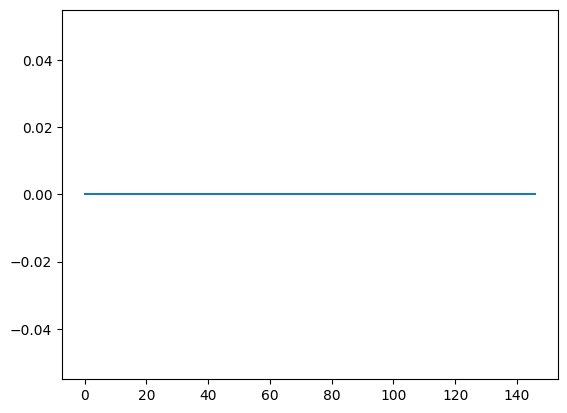

In [207]:
plt.plot(evtid_bi214_ev)

## Real Data Plots

In [245]:
#Title settings -----------------------------------------------
dcFlag_cut = 0x2100000042C2

energy_cut_title = rf'Energy cut: [{energy_inf_cut}, {energy_sup_cut}] (MeV) '
posr_cut_title = rf'R $\leq$ {posr_cut} (mm) '
dcFlag_cut_title = rf'mask = {hex(dcFlag_cut)} '

#Save figures setting -------------------------------------------
save = True
save_dir = 'figs/Real Data observable distributions/'

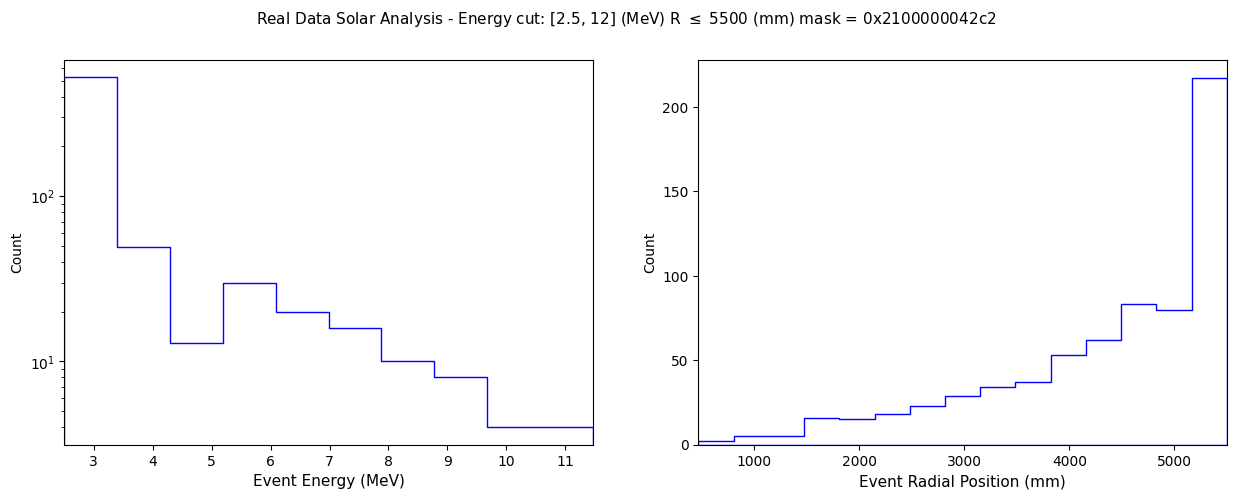

In [246]:
fig, axes = plt.subplots(1, 2,  figsize=(15, 5))

#Binning energy setting:
bins_energy = np.concatenate([
    np.linspace(3.5, 5, 5),    # 19 bins pequeños entre 0 y 4
    np.linspace(5, 12, 5)    # 9 bins más grandes entre 4 y 10
])

sn.histplot(energy_ev, ax = axes[0], bins = 10, color = 'b', element = 'step', alpha = 0)
sn.histplot(posr_ev, ax = axes[1], bins = 15, color = 'b', element = 'step', alpha = 0)

axes[0].set_yscale('log')

axes[0].set_xlabel('Event Energy (MeV)', fontsize = 11)
axes[1].set_xlabel('Event Radial Position (mm)', fontsize = 11)

plt.suptitle('Real Data Solar Analysis - ' + energy_cut_title + posr_cut_title  + dcFlag_cut_title, fontsize = 11)

axes[0].set_xlim(min(energy_ev), max(energy_ev))
axes[1].set_xlim(min(posr_ev), max(posr_ev))

if save:
    plt.savefig(f'{save_dir}energy_join_radial_distribution_E_{energy_inf_cut}_{energy_sup_cut}MeV_R_{posr_cut}mm.png', format = 'png', bbox_inches = 'tight')
plt.show()

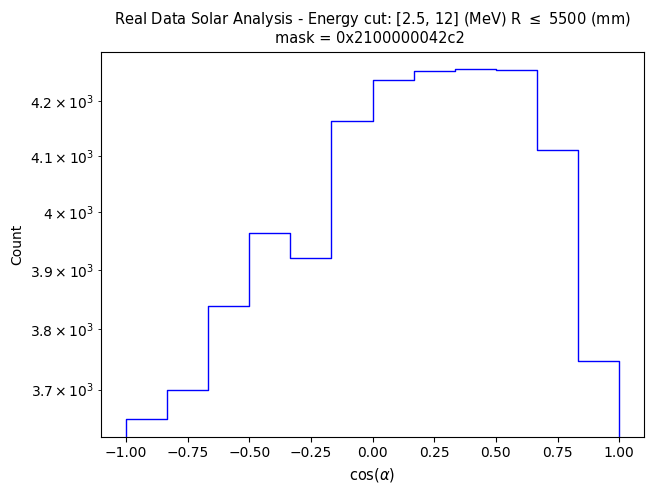

In [247]:
plt.figure(figsize = (7, 5))
sn.histplot(np.concatenate(cos_alpha_ev), bins = 12, color = 'b', element = 'step', alpha = 0)

plt.xlabel(r'cos($\alpha$)', fontsize = 10.5)
plt.title('Real Data Solar Analysis - ' + energy_cut_title + posr_cut_title  + '\n' + dcFlag_cut_title, fontsize = 10.5)

plt.yscale('log')
if save:
    plt.savefig(f'{save_dir}cos_alpha_distribution_E_{energy_inf_cut}_{energy_sup_cut}MeV_R_{posr_cut}mm.png', format = 'png', bbox_inches = 'tight')
plt.show()